In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
!pip install pyarrow

# Q1. Downloading the data
Read the data for January. How many columns are there?

In [4]:
df1 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
df1.shape

(3066766, 19)

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.
What's the standard deviation of the trips duration in January?

In [6]:
# Step 1: Check data types of columns required for duration calculation - tpep_pickup_datetime & tpep_dropoff_datetime
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
# Step 2: Calculate & add duration column to existing dataframe
df1["duration"] = (df1["tpep_dropoff_datetime"] - df1["tpep_pickup_datetime"]).dt.total_seconds() / 60
# Step 3: Calculate standard deviation of duration column values
df1["duration"].std()

42.594351241920904

## Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

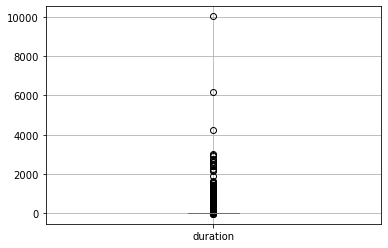

In [8]:
# Data Viaualizaion of duration outliers
boxplot = df1.boxplot(column=["duration"])

In [9]:
# Outliers remover
cleansed_df1 = df1[df1["duration"].between(1, 60, inclusive="both")]
print(f"{cleansed_df1.shape[0] * 100 / df1.shape[0]}% of records are left after dropping outliers")

98.1220282212598% of records are left after dropping outliers


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)

Fit a dictionary vectorizer

Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [10]:
# Feature selection
categorical = ["PULocationID", "DOLocationID"]
cleansed_df1[categorical] = cleansed_df1[categorical].astype(str)
cleansed_df1[categorical].dtypes

/tmp/ipykernel_47909/3342731812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleansed_df1[categorical] = cleansed_df1[categorical].astype(str)


PULocationID    object
DOLocationID    object
dtype: object

In [11]:
# Dataframe -> List of dictionaries
train_dicts = cleansed_df1[categorical].to_dict(orient='records')

In [12]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [13]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters

Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [14]:
target = "duration"
Y_train = cleansed_df1[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


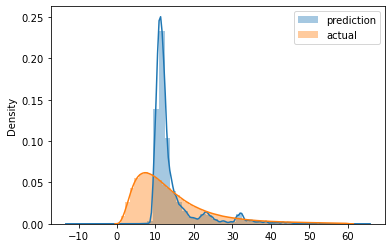

In [16]:
Y_pred = lr.predict(X_train)

# Data Visualisation
sns.distplot(Y_pred, label="prediction")
sns.distplot(Y_train, label="actual")

plt.legend()

In [17]:
# RMSE
mean_squared_error(Y_train, Y_pred, squared=False)

7.649261027919939

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [18]:
# Read the February data & execute necessary transformations
df2 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

# Calculate trip duration
df2["duration"] = (df2["tpep_dropoff_datetime"] - df2["tpep_pickup_datetime"]).dt.total_seconds() / 60
# Remove outliers
df2 = df2[df2["duration"].between(1, 60, inclusive="both")]
# Convert data types
df2[categorical] = df2[categorical].astype(str)
df2[categorical].dtypes

df2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,21.9,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,41.5,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000


In [19]:
# Dataframe -> List of dictionaries
val_dicts = df2[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
Y_val = df2[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_val)

# RMSE
mean_squared_error(Y_val, Y_pred, squared=False)

7.811832638273232